In [1]:
from model import Model
import networkx as nx
import numpy as np
from tqdm import tqdm


def create_graph(shape, n_agents, *args, **kwargs):
    if shape == "complete":
        return nx.complete_graph(n_agents)
    elif shape == "wheel":
        return nx.wheel_graph(n_agents)
    elif shape == "cycle":
        return nx.cycle_graph(n_agents)
    else:
        raise ValueError("Invalid keyword. Please choose 'complete', 'wheel', or 'cycle'.")

In [2]:
import pandas as pd
columns = [
        'n_agents',
        'shape',
        'uncertainty',
        'n_experiments',
        "n_simulations",
        "n_steps"
        ]
test_params =[
    [n_agents, shape, 0.001, 1000, 10**4, 10**8]
    for n_agents in range(5,10)
    for shape in ["complete", "wheel", "cycle"]
]
df_test = pd.DataFrame(data=test_params, columns=columns)
df_test

,n_agents,shape,uncertainty,n_experiments,n_simulations,n_steps
0,5,complete,0.001,1000,10000,100000000
1,5,wheel,0.001,1000,10000,100000000
2,5,cycle,0.001,1000,10000,100000000
3,6,complete,0.001,1000,10000,100000000
4,6,wheel,0.001,1000,10000,100000000
5,6,cycle,0.001,1000,10000,100000000
6,7,complete,0.001,1000,10000,100000000
7,7,wheel,0.001,1000,10000,100000000
8,7,cycle,0.001,1000,10000,100000000
9,8,complete,0.001,1000,10000,100000000


In [3]:
def grid_simulations(df_params: pd.DataFrame):
    results_columns = columns.append("true_consensus")
    results_df = pd.DataFrame(columns=results_columns)
    for row in tqdm(df_params.iterrows(), desc="Running simulations"):
        params = row[1]  
        for _ in range(params["n_simulations"]):
            network = create_graph(**params)
            model = Model(**params, network=network, agent_type="bayes")
            result = params.copy()
            model.run_simulation(**params, m=None)
            result["true_consensus"] = model.conclusion
            result["true_consensus_alternative_stop"] = model.conclusion_alternative_stop                
            result_row = {0: result}
            result_df = pd.DataFrame.from_dict(result_row, orient="index")
            results_df = pd.concat([results_df, result_df], ignore_index=True)
        results_df.to_csv(f"data/it{row[0]}")
    return results_df

In [4]:
results_df = grid_simulations(df_test)
results_df

Running simulations: 0it [00:00, ?it/s]

Running simulations: 15it [57:28, 229.88s/it]


,n_agents,shape,uncertainty,n_experiments,n_simulations,n_steps,true_consensus,true_consensus_alternative_stop
0,5,complete,0.001,1000,10000,100000000,0.800000,0.800000
1,5,complete,0.001,1000,10000,100000000,1.000000,1.000000
2,5,complete,0.001,1000,10000,100000000,1.000000,1.000000
3,5,complete,0.001,1000,10000,100000000,1.000000,1.000000
4,5,complete,0.001,1000,10000,100000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...
149995,9,cycle,0.001,1000,10000,100000000,1.000000,1.000000
149996,9,cycle,0.001,1000,10000,100000000,1.000000,1.000000
149997,9,cycle,0.001,1000,10000,100000000,1.000000,1.000000
149998,9,cycle,0.001,1000,10000,100000000,1.000000,1.000000


In [5]:
results_df["true_consensus_prop"] =results_df["true_consensus"]
results_df["true_consensus"] = (results_df["true_consensus"] > 0.99)

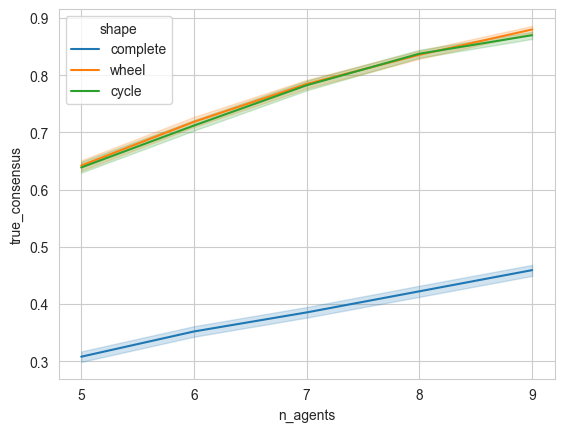

In [6]:
import seaborn as sns
sns.set_style("whitegrid")
ax = sns.lineplot(data=results_df, x="n_agents", y="true_consensus", hue="shape", markers=True, errorbar=("ci", 95))
x_min = df_test["n_agents"].min()
x_max = df_test["n_agents"].max()
ax.set_xticks(range(x_min, x_max+1))

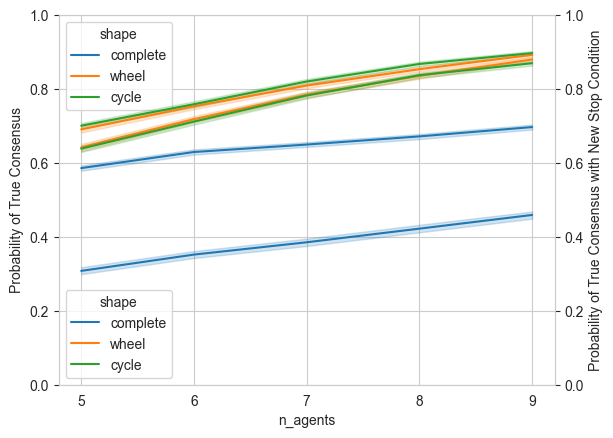

In [7]:
import matplotlib.pyplot as plt
x_min = df_test["n_agents"].min()
x_max = df_test["n_agents"].max()

# plot line chart on axis #1
ax1 = sns.lineplot(
    data=results_df, x="n_agents", y="true_consensus", hue="shape", markers=True, errorbar=("ci", 95)
)
ax1.set_ylabel('Probability of True Consensus')
ax1.set_xticks(range(x_min, x_max+1))
ax1.set_ylim(0, 1)

# set up the 2nd axis
ax2 = ax1.twinx() 

# plot bar chart on axis #2
sns.lineplot(
    data=results_df, x="n_agents", y="true_consensus_prop", hue="shape", markers=True, errorbar=("ci", 95),
    ax = ax2
)
ax2.grid(False) # turn off grid #2
ax2.set_ylabel('Probability of True Consensus with New Stop Condition')
ax2.set_ylim(0, 1)
plt.show()

In [8]:
import pandas as pd
columns = [
        'n_agents',
        'shape',
        'uncertainty',
        'n_experiments',
        "n_simulations",
        "n_steps"
        ]
test_params =[
    [6, "complete", 0.001, 1000, 10**4, 10**8]
]
df_test = pd.DataFrame(data=test_params, columns=columns)
test_result_df = grid_simulations(df_test)

Running simulations: 1it [00:52, 52.85s/it]


In [9]:
print(test_result_df["true_consensus"].mean())


0.61865
